In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


## The Vanishing/Exploding Gradient Problems

Gradients often get smaller as the algorithm progresses down to lower layers, leaving them virtually unchanged. This is the #vanishing gradients# problem. 

The opposite of this is the #exploding gradients# problem where the gradients will get larger.

Deep neural networks suffer from unstable gradients generally because different layers learn at different speeds. 

The reason is that there logistic sigmoid function and a certain weight initialization in the early 2000's was part of the reason.

Main reason is that the vairance of the output for each layer is much greater than the variance of the inputs.

### Glorot and He Initialization

Argued that we need the vairance of the outputs of each layer to match its inputs, and the gradients need to have equal variance before and after flowing in the reverse direction.

Not possible to do guarantee both unless layer has equal number of inputs and neurons(called *fan-in* and *fan-out* of the layer).

The Xavier or Glorot Initialization is fan<sub>avg</sub> = (fan<sub>in</sub> + fan<sub>out</sub>) / 2

By default, Keras uses Glorot initialization with uniform distribution.

The He initialization is also a name for ReLu.

Below is a list of initializers:

In [2]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

### Nonsaturating Activation Functions

ReLu is a great choice, but it suffers from *dying ReLu's*, where some neurons only output 0. Huge portions of the network can die, esp. with high learning rates.

To deal with that issue, the made *leaky ReLu* where when its less than zero it becomes negative instead of 0, and it then has a chance of neurons coming back to life.

High leaks seem to do really well. Parametric leaky Relu (PReLu) can be modified through backprop. Its really good for large image datasets but tends to overfit on smaller ones.

Then there is *exponential linear unit* (ELU) that performs better than ReLu. Its main con is that its slower to compute than ReLu and its variants. That it converges faster during training compensates but at test time it will be slower.

*Scaled ELU* (SELU) will self-normalize (if you only use dense layers, and all use SELU), preserving a mean of 0 and std of 1, which solves the gradient problems. It will outperform other activation functions, but it has conditions:
    - Input features must be standardized(mean=0, std=1)
    - Every hidden layer weights must be initialized with LeCun normal initialization. `kernel_initializer="lecun_normal"`
    - Network architecture must be sequential, if used on recurrent networks or networks that are Wide & Deep, self-normalization not guaranteed and performance wont necessairly outperform other functions.
    - Only dense layers, but can improve convolutional neural nets as well.
    

The general path is SELU > ELU > leaky ReLu & variants > ReLu > tanh > logistic.

If network architecure prevents self-normalizing, got to ELU. If I care about runtime latency, leaky Relu (I can set a value for it). Can also cross-validation other unctions, such as RReLu if network is overfitting or PReLu if there is a huge training set. BUT ReLu has a lot of support and is fast.  

### Batch Normalization

The `BatchNormalization` operation goes just before or after a hidden layer. The operatoin zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling and one for shifting. 

Learns the optimal scale and mean of each layer's inputs.

Most cases, using as a first layer you wont have to use things like `StandardScaler`. It will do the scaling approximately a batch at a time.

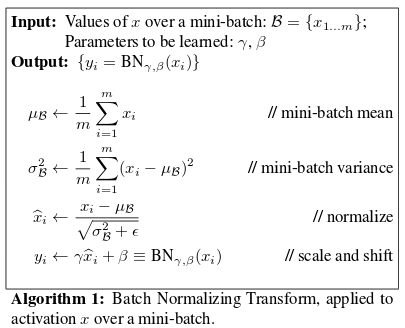


But what about at testing time for predictions? There's no way to calculate each inputs mean and std. One solution would be to wait until the end of training, run the training set through the network and compute the mean and std of each input of the BN layer. These final input means and stds could then be used to make predictions instead of the batch ones. 

But what Keras does is calculate a moving average.
Four parameters are learned in each batch-normalized layer:
The $\gamma$ (output scale vector) and $\beta$ (output offset vector) are learned through backpropagation, $\mu$ (final input mean vector) and $\delta$ (final input standard deviation vector) are estimated using an exponential moving average. $\mu$ and $\delta$ are only used after training.

Pros of Batch Normalization:
- Vanishing gradient problems reduced to the point you can even use saturating activation functions like *tanh* or *logistic*. 
- Less sensitive to weight initialization
- Can use larger learning rates
- Acts like a regularizer
- Can remove the need to standardize input

Cons:
- Slows down predictions due to extra calculations required at runtime

But the con can be negated by fusing the BN layer to the previous one, TFLite's optimizer(Ch19) does this automatically.

In [5]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [6]:
#unlikely for a model this size its going to make a big 
#difference, but its worth it in deep networks
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)               400       
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

The BN layers add 4 * 784 params, this is $\gamma$, $\beta$, $\mu$, and $\delta$. 

The $\mu$ and $\delta$ are the moving final averages, so Keras lists them as non-trainable, adding up all BN layer params and dividing by two gives "Non-trainable params" value.

In [7]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization_3/gamma:0', True),
 ('batch_normalization_3/beta:0', True),
 ('batch_normalization_3/moving_mean:0', False),
 ('batch_normalization_3/moving_variance:0', False)]

In [10]:
# creates two operations that are called per iteration
bn1 = model.layers[1]
bn1.updates

# .updates doesn't seem to work in TF 2.0, prob 
# a new way to see whats below

'''
[<tf.Operation 'cond/Identity' type=Identity>,
 <tf.Operation 'cond_1/Identity' type=Identity>]
'''

"\n[<tf.Operation 'cond/Identity' type=Identity>,\n <tf.Operation 'cond_1/Identity' type=Identity>]\n"

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a BatchNormalization layer does not need to have bias terms, since the $\beta$ (output offset vector) is included in BN, **it would be a waste of parameters**, so you can set use_bias=False when creating those layers:



In [11]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100,use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

#### Batch Normalization hyperparameters:

Momentum: used when the BN layer updates the exponential moving average. 

v -> v x momentum + v x (1 - momentum)

v is a new vector of input means and std computed from the current batch. Good momemtum values are close to one (0.9, 0.99, 0.999), more 9's for larger datasets and smaller mini-batches.

Axis: